In [27]:
import numpy as np
import pandas as pd
# from sklearn.preprocessing import
from sklearn.model_selection import train_test_split
from random import randint
import sklearn.metrics as skm
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

In [28]:
def replace_rare_entries(df, columns, threshold_frac):
    tot_instances = df.shape[0]
    threshold = tot_instances * threshold_frac
    df = df.apply(lambda x: x.mask(x.map(x.value_counts()) < threshold, 'RARE') if x.name in columns else x)
    return df
    

In [29]:
categoricals = ['OP_UNIQUE_CARRIER', 'DEST', 'DEP_TIME_BLK', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'MONTH','weather_label']
numericals = ['precipitation_intensity','precipitation_probability','visibility','cloud_cover','humidity','wind_bearing','wind_speed','uv_index','temperature','moon_phase','dew_point','pressure','sunrise_time','sunset_time']

In [30]:
df = pd.read_csv('../Data/new_york/year_lga_dep_weather.csv')

In [31]:
data = df.drop([col for col in df.columns if (col not in categoricals and col not in numericals)], axis=1)
data = replace_rare_entries(data, ['DEST'], 0.005)
data = replace_rare_entries(data, ['UNIQUE_CARRIER'], 0.005)
data = pd.get_dummies(data, columns=categoricals)
label = df['DEP_DEL15']

In [32]:
data.columns

Index(['precipitation_intensity', 'precipitation_probability', 'visibility',
       'cloud_cover', 'humidity', 'wind_bearing', 'wind_speed', 'uv_index',
       'temperature', 'moon_phase',
       ...
       'MONTH_12', 'weather_label_WeatherLabel.ClearDay',
       'weather_label_WeatherLabel.ClearNight',
       'weather_label_WeatherLabel.Cloudy', 'weather_label_WeatherLabel.Fog',
       'weather_label_WeatherLabel.PartlyCloudyDay',
       'weather_label_WeatherLabel.PartlyCloudyNight',
       'weather_label_WeatherLabel.Rain', 'weather_label_WeatherLabel.Sleet',
       'weather_label_WeatherLabel.Snow'],
      dtype='object', length=158)

In [33]:
data = data[~label.isna()]
label = label[~label.isna()]

In [34]:
print('Rows: {}\nFeatures: {}\nLabel-1 Fraction: {}'
      .format(data.shape[0], data.shape[1], label.sum() / label.shape[0]))

Rows: 181088
Features: 158
Label-1 Fraction: 0.21473537727513695


In [35]:
thres = np.linspace(0, 1, 500)

In [36]:
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=label)

In [37]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=y)
Dtrain = xgb.DMatrix(x_train, label=y_train)
Dval = xgb.DMatrix(x_val, label=y_val)

/home/erez/shared_venv_3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [38]:
y_train.shape[0]

115896

In [39]:
param = {                              # General guidelines for initial paramaters:
    'min_child_weight': 1,             # 1 (choose small for high class imbalance)
    'gamma': 0.3,                        # 0.1-0.2
    'lambda': 0,  #1                     # L2 Regulariztion - default = 1
    'scale_pos_weight': 4,             # 1 (choose small for high class imbalance)
    'subsample': 0.6,                    # 0.5-0.9
    'colsample_bytree': 0.8,             # 0.5-0.9
    'colsample_bylevel': 0.7,              # 0.5-0.9
    'max_depth': 6,  #5                  # 3-10 
    'eta': 0.1,                        # 0.05-0.3
    'silent': 0,                       # 0 - prints progress    1 - quiet
    'objective': 'binary:logistic',        
    'num_class': 1,             
    'eval_metric': 'auc'}  
num_round = 10000                                      # the number of training iterations if not stopped early
evallist = [(Dtrain, 'train'), (Dval, 'eval')]        # Specify validation set to watch performance

In [40]:
# Train the model on the training set to get an initial impression on the performance
model = xgb.train(param, Dtrain, num_round, evallist, early_stopping_rounds=10)
print("Best error: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	train-auc:0.707297	eval-auc:0.699337
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.726162	eval-auc:0.717123
[2]	train-auc:0.735941	eval-auc:0.72378
[3]	train-auc:0.738586	eval-auc:0.727576
[4]	train-auc:0.742002	eval-auc:0.729966
[5]	train-auc:0.74413	eval-auc:0.732707
[6]	train-auc:0.74832	eval-auc:0.736977
[7]	train-auc:0.751503	eval-auc:0.740192
[8]	train-auc:0.75306	eval-auc:0.741764
[9]	train-auc:0.75478	eval-auc:0.743582
[10]	train-auc:0.756732	eval-auc:0.745311
[11]	train-auc:0.75847	eval-auc:0.746524
[12]	train-auc:0.75978	eval-auc:0.747948
[13]	train-auc:0.761955	eval-auc:0.750082
[14]	train-auc:0.762793	eval-auc:0.750688
[15]	train-auc:0.763681	eval-auc:0.751193
[16]	train-auc:0.76595	eval-auc:0.753217
[17]	train-auc:0.767739	eval-auc:0.754294
[18]	train-auc:0.768983	eval-auc:0.755108
[19]	train-auc:0.770205	eval-auc:0.756079
[20]	train-auc:0.771801	eval-auc:0.75

[191]	train-auc:0.846748	eval-auc:0.796098
[192]	train-auc:0.846899	eval-auc:0.796177
[193]	train-auc:0.847081	eval-auc:0.796291
[194]	train-auc:0.847432	eval-auc:0.796219
[195]	train-auc:0.847784	eval-auc:0.796363
[196]	train-auc:0.847943	eval-auc:0.796485
[197]	train-auc:0.848101	eval-auc:0.796559
[198]	train-auc:0.8483	eval-auc:0.796546
[199]	train-auc:0.848448	eval-auc:0.79648
[200]	train-auc:0.848622	eval-auc:0.796585
[201]	train-auc:0.848952	eval-auc:0.79649
[202]	train-auc:0.849163	eval-auc:0.796473
[203]	train-auc:0.84938	eval-auc:0.796531
[204]	train-auc:0.849517	eval-auc:0.796473
[205]	train-auc:0.849746	eval-auc:0.796473
[206]	train-auc:0.850006	eval-auc:0.796435
[207]	train-auc:0.850336	eval-auc:0.796515
[208]	train-auc:0.850637	eval-auc:0.796542
[209]	train-auc:0.850786	eval-auc:0.796606
[210]	train-auc:0.85106	eval-auc:0.796585
[211]	train-auc:0.851221	eval-auc:0.796517
[212]	train-auc:0.851424	eval-auc:0.796454
[213]	train-auc:0.851564	eval-auc:0.796468
[214]	train-auc:0

In [41]:
Dtest = xgb.DMatrix(x_test, label=y_test)
probas = model.predict(Dtest)
y_test = Dtest.get_label()

/home/erez/shared_venv_3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/erez/shared_venv_3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


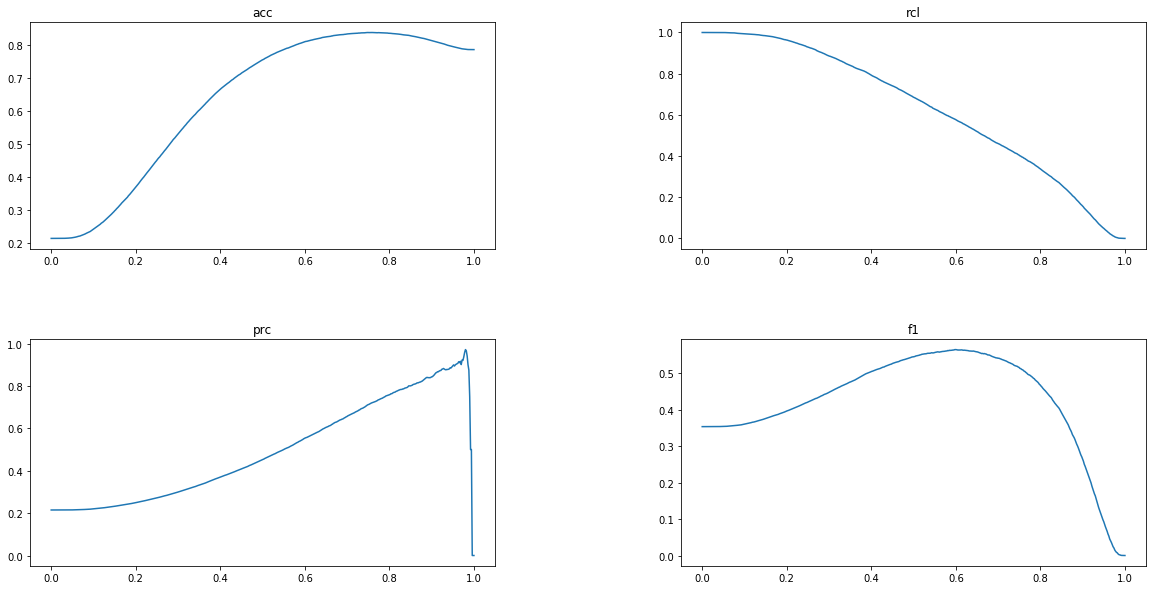

In [42]:
accs, recalls, precs, f1s = [], [], [], []
for thr in thres:
    y_pred = (probas > thr).astype(int)
    accs.append(skm.accuracy_score(y_test, y_pred))
    recalls.append(skm.recall_score(y_test, y_pred))
    precs.append(skm.precision_score(y_test, y_pred))
    f1s.append(skm.f1_score(y_test, y_pred))
    
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, (metric, name) in enumerate(zip([accs, recalls, precs, f1s], ['acc', 'rcl', 'prc', 'f1']), start=1):
    fig.add_subplot(2, 2, i)
    plt.plot(thres, metric)
    plt.title(name)


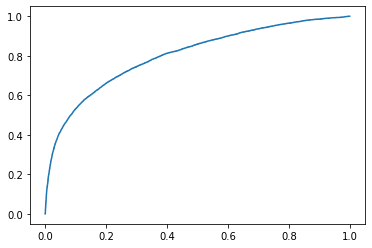

In [43]:
tpr, fpr, _ = roc_curve(y_test, probas)
plt.plot(tpr, fpr);

In [50]:
best_thres = thres[np.argmax(f1s)]
y_pred = (probas > best_thres).astype(int)
print('Acc for max f1 threshold: ', skm.accuracy_score(y_test, y_pred))
print('Max acc : ', max(accs))
print('Precision : ', skm.precision_score(y_test, y_pred))
print('Recall : ', skm.recall_score(y_test, y_pred))
print('AUC : ', skm.auc(tpr, fpr))

Acc for max f1 threshold:  0.8089900049699045
Max acc :  0.8369871334695456
Precision :  0.5528745537363043
Recall :  0.5774720329175774
AUC :  0.8021782895262507


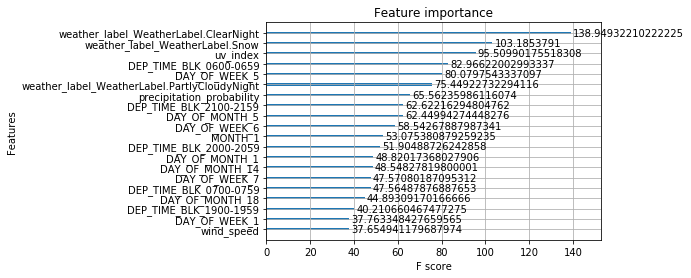

In [53]:
xgb.plot_importance(model, max_num_features=20, importance_type='gain');